# Example Notebook for the tunneling Fermions

This Notebook is based on the following [paper](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.114.080402) from the Jochim group. In these experiments two fermions of different spins are put into a single tweezer and then coupled to a second tweezer. The dynamics is then controlled by two competing effects. The interactions and the tunneling. 

Let us first start by looking at the data, then look how the can be described in the Hamiltonian language and finally in the gate language.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt


import pandas as pd

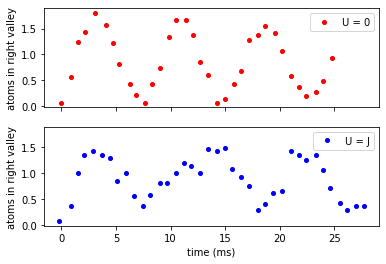

In [2]:
data_murmann_no_int = pd.read_csv("Data/Murmann_No_Int.csv", names=["time", "nR"])
data_murmann_with_int = pd.read_csv("Data/Murmann_With_Int.csv", names=["time", "nR"])

# plt.figure(dpi=96)
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
ax1.plot(
    data_murmann_no_int.time, data_murmann_no_int.nR, "ro", label="U = 0", markersize=4
)
ax2.plot(
    data_murmann_with_int.time,
    data_murmann_with_int.nR,
    "bo",
    label="U = J",
    markersize=4,
)
ax1.set_ylabel(r"atoms in right valley")
ax2.set_ylabel(r"atoms in right valley")
ax2.set_xlabel(r"time (ms)")
ax1.legend()
ax2.legend()

## Analytical prediction

For the two atoms the Hamiltonian can be written down in the basis $\{LL, LR, RL, RR\}$ as:
    
$$
H = \left(\begin{array}{cccc}
U & -J & -J & 0\\
-J & 0 & 0 &-J\\
-J & 0 & 0 &-J\\
0 & -J & -J & U
            \end{array}
            \right)
$$

And we start out in the basis state $|LL\rangle$. So we can write

In [3]:
from scipy.sparse.linalg import expm

In [4]:
J = np.pi * 134
# in units of hbar
U = 0.7 * J;

In [5]:
Nt_an = 50
t_analytical = np.linspace(0, 20, Nt_an) * 1e-3
H_With_Int = np.array([[U, -J, -J, 0], [-J, 0, 0, -J], [-J, 0, 0, -J], [0, -J, -J, U]])
H_Wo_Int = np.array([[0, -J, -J, 0], [-J, 0, 0, -J], [-J, 0, 0, -J], [0, -J, -J, 0]])

In [6]:
psi0 = np.zeros(4) * 1j
psi0[0] = 1.0 + 0j
print(psi0)

[1.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [7]:
psis_wo_int = 1j * np.zeros((4, Nt_an))
psis_w_int = 1j * np.zeros((4, Nt_an))

for ii in np.arange(Nt_an):

    U_wo = expm(-1j * t_analytical[ii] * H_Wo_Int)
    psis_wo_int[:, ii] = np.dot(U_wo, psi0)

    U_w = expm(-1j * t_analytical[ii] * H_With_Int)
    psis_w_int[:, ii] = np.dot(U_w, psi0)

ps_wo = np.abs(psis_wo_int) ** 2
ps_w = np.abs(psis_w_int) ** 2

In [8]:
nR_wo = ps_wo[1, :] + ps_wo[2, :] + 2 * ps_wo[3, :]
nR_w = ps_w[1, :] + ps_w[2, :] + 2 * ps_w[3, :];

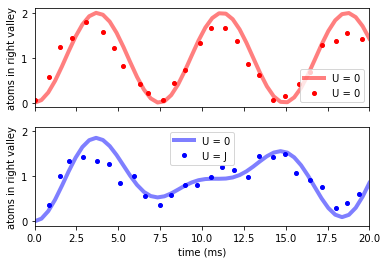

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
ax1.plot(t_analytical * 1e3, nR_wo, "r-", label="U = 0", linewidth=4, alpha=0.5)
ax1.plot(
    data_murmann_no_int.time, data_murmann_no_int.nR, "ro", label="U = 0", markersize=4
)

ax2.plot(t_analytical * 1e3, nR_w, "b-", label="U = 0", linewidth=4, alpha=0.5)
ax2.plot(
    data_murmann_with_int.time,
    data_murmann_with_int.nR,
    "bo",
    label="U = J",
    markersize=4,
)
ax1.set_ylabel(r"atoms in right valley")
ax2.set_ylabel(r"atoms in right valley")
ax2.set_xlabel(r"time (ms)")
ax2.set_xlim(0, 20)
ax1.legend()
ax2.legend()

## Pennylane

And now we also compare to the pennylane simulation. Make sure that you followed the necessary steps for obtaining the credentials as desribed in the [introduction](https://synqs.github.io/pennylane-ls/intro.html).

In [10]:
from pennylane_ls import *
from heroku_credentials import username, password

In [11]:
FermionDevice = qml.device("synqs.fs", shots=500, username=username, password=password)

In the experiments two Fermions are loaded onto the right side, i.e. into the wire 0 and 1. 

## No interaction
In a first set of experiments there are no interactions and the two atoms are simply allowed to hop. The experiment is then described by the following very simple circuit.

In [13]:
@qml.qnode(FermionDevice)
def simple_hopping(theta=0):
    """
    The circuit that simulates the experiments.

    theta ... angle of the hopping
    """
    # load atoms
    fermion_ops.Load(wires=0)
    fermion_ops.Load(wires=1)

    # let them hop
    fermion_ops.Hop(theta, wires=[0, 1, 2, 3])

    # measure the occupation on the right side
    obs = fermion_ops.ParticleNumber([2, 3])
    return qml.expval(obs)

In [18]:
print(qml.draw(simple_hopping)(0))

 0: ──Load──╭Hop(0)───┤                  
 1: ──Load──├Hop(0)───┤                  
 2: ────────├Hop(0)──╭┤ ⟨ParticleNumber⟩ 
 3: ────────╰Hop(0)──╰┤ ⟨ParticleNumber⟩ 



now let us simulate the time evolution

In [19]:
Ntimes = 15
times = np.linspace(0, 20, Ntimes) * 1e-3
means = np.zeros(Ntimes)
for i in range(Ntimes):
    if i % 10 == 0:
        print("step", i)
    # Calculate the resulting states after each rotation
    means[i] = sum(simple_hopping(-2 * J * times[i]))

step 0
step 10


and compare to the data

(0.0, 20.0)

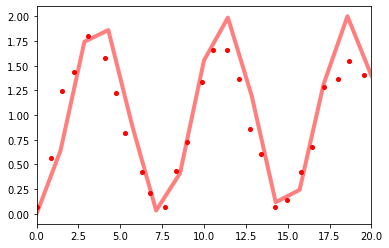

In [20]:
f, ax1 = plt.subplots(1, 1, sharex=True, sharey=True)
ax1.plot(times * 1e3, means, "r-", label="U = 0", linewidth=4, alpha=0.5)
ax1.plot(
    data_murmann_no_int.time, data_murmann_no_int.nR, "ro", label="U = 0", markersize=4
)
ax1.set_xlim(0, 20)

## Hopping with interactions

In a next step the atoms are interacting. The circuit description of the experiment is the application of the hopping gate and the interaction gate. It can be written as

In [22]:
@qml.qnode(FermionDevice)
def correlated_hopping(theta=0, gamma=0, Ntrott=15):
    """
    The circuit that simulates the experiments.

    theta ... angle of the hopping
    gamma ... angle of the interaction
    """
    # load atoms
    fermion_ops.Load(wires=0)
    fermion_ops.Load(wires=1)

    # let them hop
    # evolution under the Hamiltonian
    for ii in range(Ntrott):
        fermion_ops.Hop(theta / Ntrott, wires=[0, 1, 2, 3])
        fermion_ops.Inter(gamma / Ntrott, wires=[0, 1, 2, 3, 4, 5, 6, 7])

    # measure the occupation on the right side
    obs = fermion_ops.ParticleNumber([2, 3])
    return qml.expval(obs)

In [23]:
print(qml.draw(correlated_hopping)(0, 0, 2))

 0: ──Load──╭Hop(0)──╭Inter(0)──╭Hop(0)──╭Inter(0)───┤                  
 1: ──Load──├Hop(0)──├Inter(0)──├Hop(0)──├Inter(0)───┤                  
 2: ────────├Hop(0)──├Inter(0)──├Hop(0)──├Inter(0)──╭┤ ⟨ParticleNumber⟩ 
 3: ────────╰Hop(0)──├Inter(0)──╰Hop(0)──├Inter(0)──╰┤ ⟨ParticleNumber⟩ 
 4: ─────────────────├Inter(0)───────────├Inter(0)───┤                  
 5: ─────────────────├Inter(0)───────────├Inter(0)───┤                  
 6: ─────────────────├Inter(0)───────────├Inter(0)───┤                  
 7: ─────────────────╰Inter(0)───────────╰Inter(0)───┤                  



In [ ]:
Ntimes = 15
times = np.linspace(0, 20, Ntimes) * 1e-3
means_int = np.zeros(Ntimes)
for i in range(Ntimes):
    if i % 10 == 0:
        print("step", i)
    means_int[i] = sum(correlated_hopping(-2 * J * times[i], U * times[i]))

And we compare to the data to obtain

In [ ]:
f, ax2 = plt.subplots(1, 1, sharex=True, sharey=True)

ax2.plot(times * 1e3, means_int, "b-", label="simulation", linewidth=4, alpha=0.5)
ax2.plot(
    data_murmann_with_int.time,
    data_murmann_with_int.nR,
    "bo",
    label="U = J",
    markersize=4,
)
ax2.set_ylabel(r"atoms in right valley")
ax2.set_xlabel(r"time (ms)")
ax2.legend()
ax2.set_xlim(0, 20)

## Summary

And finally we can compare the experimental data with all the descriptions.

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)


ax1.plot(times * 1e3, means, "r-", label="pennylane", linewidth=4, alpha=0.5)
ax1.plot(t_analytical * 1e3, nR_wo, "b-.", label="analytical", linewidth=4, alpha=0.5)
ax1.plot(
    data_murmann_no_int.time,
    data_murmann_no_int.nR,
    "ro",
    label="experiment",
    markersize=4,
)

ax2.plot(times * 1e3, means_int, "r-", label="pennylane", linewidth=4, alpha=0.5)
ax2.plot(t_analytical * 1e3, nR_w, "b-.", label="analytical", linewidth=4, alpha=0.5)
ax2.plot(
    data_murmann_with_int.time,
    data_murmann_with_int.nR,
    "ro",
    label="experiment",
    markersize=4,
)
ax1.set_ylabel(r"atoms in right valley")
ax2.set_ylabel(r"atoms in right valley")
ax2.set_xlabel(r"time (ms)")
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
ax1.set_xlim(-1, 20)